## Imports, data load, metric function definition

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt
import time
import os

import plotly.express as px
import random
import numpy.random as npr
from sklearn.model_selection import train_test_split

dossier = 'D:/DocDataM2/S3UE1_Datachallenge/'
os.chdir(dossier)

In [3]:
X_npz = np.load('X_train_surge_new.npz')


In [4]:
for cle in X_npz:
    print( type(X_npz[cle]), '  ', cle, '\t\t', X_npz[cle].shape )

cles = list(X_npz.keys())
print(cles)
print()

<class 'numpy.ndarray'>    id_sequence 		 (5599,)
<class 'numpy.ndarray'>    t_slp 		 (5599, 40)
<class 'numpy.ndarray'>    slp 		 (5599, 40, 41, 41)
<class 'numpy.ndarray'>    t_surge1_input 		 (5599, 10)
<class 'numpy.ndarray'>    surge1_input 		 (5599, 10)
<class 'numpy.ndarray'>    t_surge2_input 		 (5599, 10)
<class 'numpy.ndarray'>    surge2_input 		 (5599, 10)
<class 'numpy.ndarray'>    t_surge1_output 		 (5599, 10)
<class 'numpy.ndarray'>    t_surge2_output 		 (5599, 10)
['id_sequence', 't_slp', 'slp', 't_surge1_input', 'surge1_input', 't_surge2_input', 'surge2_input', 't_surge1_output', 't_surge2_output']



In [5]:
##### choix des données d'entrainement  : #####
taux = 0.6

slice_train = np.bool_(npr.binomial(1,taux,5599))
k_train = range(5599)*slice_train

print('Train :')
print(slice_train[:10])
print(k_train[:10])
n_train = sum(slice_train)

k_train.sort()
k_train = k_train[5599-n_train:]  # on enlève tous les zeros
print(k_train)


##### choix des données de test  : #####
slice_test = ~slice_train
k_test = range(5599)*slice_test

print('Test :')
print(slice_test[:10])
print(k_test[:10])
n_test = 5599 - n_train

k_test.sort()
k_test = k_test[5599-n_test:]  # on enlève tous les zeros
print(k_test)


Train :
[ True  True  True False  True False  True  True  True False]
[0 1 2 0 4 0 6 7 8 0]
[   0    1    2 ... 5593 5594 5595]
Test :
[False False False  True False  True False False False  True]
[0 0 0 3 0 5 0 0 0 9]
[   3    5    9 ... 5596 5597 5598]


In [6]:
# Transformer les données en df_train
df_train = pd.DataFrame(index = range(n_train))

# On commence par construire un df qui contient la première valeurs des listes t_spl
df_train[f't_slp_begin'] = list(X_npz['t_slp'][slice_train][:,0])
df_train.head(5)


##### Même chose avec les données de test #####
df_test = pd.DataFrame(index = range(n_test))
df_test[f't_slp_begin'] = list(X_npz['t_slp'][slice_test][:,0])
df_test.head(5)

,t_slp_begin
0,-630806400.0
1,-630622784.0
2,-630266368.0
3,-630179968.0
4,-628387200.0


In [8]:

# MESSAGE WARNING CAR "df[''] = ..." est inefficace (lent) comparé à pd.concat(...)

"""# on ajoute les image slp

# selection des slp (sur les 40 pas de temps disponibles)
which_slp = [0,1,2,3,10,20,30]   # 40 valeurs de 0 à 39

# pas du saut de pixels (prendre 1 pixel / par, et ignorer les autres)
pas = 2

data_tr =  X_npz['slp'][slice_train]
for k in which_slp:
    if k%pas == 0:
        print(k, end=' ; ')
        #print(X_npz['slp'].shape)
        #print(X_npz['slp'][slice_train][:,k,:,:].shape)
        for i in range(41):
            for j in range(41):
                # liste pour chaque ligne des valeurs du pixels (i,j) pour la date k
                df_train[f"slp{k}_x_{i}_y_{j}"] = data_tr[:,k,i,j]  

#print()
#print(df_train.head(5))


##### Même chose avec les données de test #####

data_te =  X_npz['slp'][slice_test]
for k in which_slp:
    if k%pas == 0:
        print(k, end=' ; ')
        for i in range(41):
            for j in range(41):
                df_test[f"slp{k}_x_{i}_y_{j}"] = data_te[:,k,i,j]  

print()
df_test.head(5)"""

print()

In [9]:
# on ajoute les image slp

# selection des slp (sur les 40 pas de temps disponibles)
which_slp = [0,1,2,3,10,20,30]   # 40 valeurs de 0 à 39

# pas du saut de pixels (prendre 1 pixel / par, et ignorer les autres)
pas = 2


print("Traitement des données d'entrainement :")
data_tr =  X_npz['slp'][slice_train]
for k in which_slp:
    print(k, end=' ; ')
    #print(X_npz['slp'].shape)
    #print(X_npz['slp'][slice_train][:,k,:,:].shape)
    for i in range(41):
        for j in range(41):
            if (i+j)%pas == 0:  # ignorer certains pixels
                # liste pour chaque ligne des valeurs du pixels (i,j) pour la date k
                df_temp = pd.DataFrame(data_tr[:,k,i,j], columns=[f"slp{k}_x_{i}_y_{j}"] ) 
                df_train = pd.concat([df_train, df_temp], axis=1)

#print()
#print(df_train.head(5))


##### Même chose avec les données de test #####
print("\nTraitement des données de test :")
data_te =  X_npz['slp'][slice_test]
for k in which_slp:
    
    print(k, end=' ; ')
    for i in range(41):
        for j in range(41):
            if (i+j)%pas == 0:
                df_temp = pd.DataFrame(data_te[:,k,i,j], columns=[f"slp{k}_x_{i}_y_{j}"] ) 
                df_test = pd.concat([df_test, df_temp], axis=1)
print()
df_test.head(5)

Traitement des données d'entrainement :
0 ; 1 ; 2 ; 3 ; 10 ; 20 ; 30 ; 
Traitement des données de test :
0 ; 1 ; 2 ; 3 ; 10 ; 20 ; 30 ; 


,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_2,slp0_x_0_y_4,slp0_x_0_y_6,slp0_x_0_y_8,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,...,slp30_x_40_y_22,slp30_x_40_y_24,slp30_x_40_y_26,slp30_x_40_y_28,slp30_x_40_y_30,slp30_x_40_y_32,slp30_x_40_y_34,slp30_x_40_y_36,slp30_x_40_y_38,slp30_x_40_y_40
0,-630806400.0,101366.406250,101476.406250,101672.406250,101822.406250,101939.406250,102020.406250,102048.406250,102031.406250,101985.406250,...,102022.093750,101981.093750,101930.093750,101868.093750,101809.093750,101747.093750,101696.093750,101662.093750,101664.093750,101709.093750
1,-630622784.0,100756.898438,100695.898438,100628.898438,100572.898438,100572.898438,100682.898438,100893.898438,101095.898438,101268.898438,...,100498.757812,100501.757812,100509.757812,100525.757812,100580.757812,100685.757812,100865.757812,101104.757812,101359.757812,101594.757812
2,-630266368.0,102235.179688,102265.179688,102324.179688,102367.179688,102386.179688,102372.179688,102338.179688,102285.179688,102192.179688,...,99410.203125,99452.203125,99530.203125,99636.203125,99760.203125,99892.203125,100021.203125,100136.203125,100237.203125,100318.203125
3,-630179968.0,102335.101562,102281.101562,102263.101562,102257.101562,102248.101562,102229.101562,102192.101562,102137.101562,102082.101562,...,100258.226562,100114.226562,99997.226562,99907.226562,99860.226562,99852.226562,99875.226562,99916.226562,99965.226562,100020.226562
4,-628387200.0,102815.453125,102780.453125,102731.453125,102668.453125,102593.453125,102511.453125,102409.453125,102283.453125,102130.453125,...,99316.851562,99167.851562,99020.851562,98888.851562,98787.851562,98721.851562,98693.851562,98686.851562,98710.851562,98744.851562


In [10]:
# TRAITEMENT DES t_surgeX et surge_X

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


print("Traitement des données d'entrainement :")

# On ajoute les 't_surgeX_input' (en ne gardant que la première valeur)
liste_temp = ['t_surge1_input', 't_surge2_input'] 
for feature in liste_temp:
    df_train[feature] = list(X_npz[feature][slice_train][:,0])

# puis on ajoute les 'surgeX_input' (tous)
liste_temp = ['surge1_input', 'surge2_input'] 
for feature in liste_temp:
    print(feature, end=":")
    for k in range(10):
        print(k, end=" ; ")
        df_train[f"{feature}_{k}"] = list(X_npz[feature][slice_train][:,k])


##### Même chose avec les données de test #####
print("\nTraitement des données de test :")

liste_temp = ['t_surge1_input', 't_surge2_input'] 
for feature in liste_temp:
    df_test[feature] = list(X_npz[feature][slice_test][:,0])

liste_temp = ['surge1_input', 'surge2_input'] 
for feature in liste_temp:
    print(feature, end=":")
    for k in range(10):
        print(k, end=" ; ")
        df_test[f"{feature}_{k}"] = list(X_npz[feature][slice_test][:,k])



Traitement des données d'entrainement :
surge1_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; surge2_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
Traitement des données de test :
surge1_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; surge2_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 

In [11]:
# traitement des t_surgeX_output

for k in [1,2]:
    df_train[f't_surge{k}_output'] = X_npz[f't_surge{k}_output'][slice_train][:,0]
    df_test[f't_surge{k}_output'] = X_npz[f't_surge{k}_output'][slice_test][:,0]

In [12]:
df_train.head(2)
df_test.head(2)

,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_2,slp0_x_0_y_4,slp0_x_0_y_6,slp0_x_0_y_8,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,...,surge2_input_2,surge2_input_3,surge2_input_4,surge2_input_5,surge2_input_6,surge2_input_7,surge2_input_8,surge2_input_9,t_surge1_output,t_surge2_output
0,-630806400.0,101366.406250,101476.406250,101672.406250,101822.406250,101939.406250,102020.406250,102048.406250,102031.406250,101985.406250,...,-0.179620,-0.372413,-0.053886,0.356847,0.348464,0.264641,0.901696,0.449052,-630399616.0,-630392384.0
1,-630622784.0,100756.898438,100695.898438,100628.898438,100572.898438,100572.898438,100682.898438,100893.898438,101095.898438,101268.898438,...,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-630219584.0,-630212416.0


In [13]:
# Prend quelques minutes
"""
df_train.to_csv('export_X_train.csv')  # je n'obtiens pas ce que je veux (les données sont des chaines de caractères)
df_test.to_csv('export_X_test.csv')
"""

"\ndf_train.to_csv('export_X_train.csv')  # je n'obtiens pas ce que je veux (les données sont des chaines de caractères)\ndf_test.to_csv('export_X_test.csv')\n"

In [14]:
# Création des variables d'entrées X pour chacune des villes 1 et 2:

colonnes_unique_1 = ['t_surge1_input', 't_surge1_output']+[f'surge1_input_{k}' for k in range(10)]
colonnes_unique_2 = ['t_surge2_input', 't_surge1_output']+[f'surge2_input_{k}' for k in range(10)]

X_train_1 = df_train[df_train.columns.difference(colonnes_unique_2)]
X_train_2 = df_train[df_train.columns.difference(colonnes_unique_1)]

X_train_1.head(3)

##### Même chose avec les données de test #####
X_test_1 = df_test[df_test.columns.difference(colonnes_unique_2)]
X_test_2 = df_test[df_test.columns.difference(colonnes_unique_1)]

X_test_1.head(3)

,slp0_x_0_y_0,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,slp0_x_0_y_18,slp0_x_0_y_2,slp0_x_0_y_20,slp0_x_0_y_22,slp0_x_0_y_24,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,101366.406250,102020.406250,102048.406250,102031.406250,101985.406250,101936.406250,101476.406250,101890.406250,101844.406250,101797.406250,...,-1.712328,0.586936,1.069580,0.767928,-0.100162,0.070775,-0.244285,-630806400.0,-630842368.0,-630392384.0
1,100756.898438,100682.898438,100893.898438,101095.898438,101268.898438,101417.898438,100695.898438,101548.898438,101884.898438,101917.898438,...,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-630622784.0,-630662400.0,-630212416.0
2,102235.179688,102372.179688,102338.179688,102285.179688,102192.179688,102051.179688,102265.179688,101899.179688,102111.179688,102124.179688,...,-0.210768,0.288635,-0.726929,-0.576103,1.160076,0.442813,0.305393,-630266368.0,-630309632.0,-629848832.0


### Récuperer Y_train et Y_test

In [15]:
Y = pd.read_csv('Y_train_surge.csv')
print(len(Y))

"""
for cle in Y:
    print( type(Y[cle]), '\t', cle, '\t', Y[cle].shape)
"""

Y.head(3)

5599


,id_sequence,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,...,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,1,0.586936,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,...,-0.053886,0.356847,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057
1,2,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,...,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703
2,3,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,...,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733


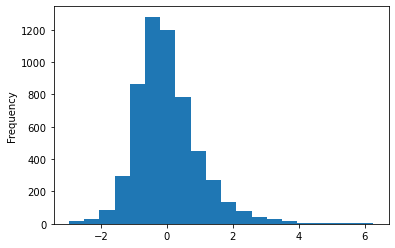

In [16]:
Y['surge1_t0'].plot(kind='hist', bins=20 )
plt.show()

In [17]:
TYPE = 'train'
i = 1
j =0

exec(f"Y_{TYPE}_{i}_{j} = list(Y['surge{i}_t{j}'][slice_{TYPE}])")

In [18]:
# Création des variables de sortie Y : 
# 40 listes de la forme Y_{TYPE}_{i}_{j}
#       Y_train_1_0 à Y_train_2_9
# ainsi que :
#       Y_test_1_0 à Y_test_2_9

for TYPE in ['train', 'test']:
    print("TYPE :")
    for i in [1,2]:                 # Parcours des lieux à prédir
        print("\tLieux", i, end=" : ")
        for j in range(10):         # Parcours des pas de temps à prédir   
            print(j, end = " ; ") 
            exec(f"Y_{TYPE}_{i}_{j} = list(Y['surge{i}_t{j}'][slice_{TYPE}])")
        print()

Y_train_1_1[:5]

TYPE :
	Lieux 1 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
	Lieux 2 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
TYPE :
	Lieux 1 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 
	Lieux 2 : 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 


[1.069580235233971,
 -0.1001618988332443,
 -0.2442848551796348,
 -0.3750010248891516,
 -0.7269291741070817]

3386

In [19]:
## Mesure de la qualité de la prédicition

def surge_prediction_metric(dataframe_y_true, dataframe_y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_columns = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_columns = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (weights * (dataframe_y_true[surge1_columns].values - dataframe_y_pred[surge1_columns].values)**2).mean()
    surge2_score = (weights * (dataframe_y_true[surge2_columns].values - dataframe_y_pred[surge2_columns].values)**2).mean()

    return surge1_score + surge2_score

In [20]:
# pre proccessing : centrer reduire les données

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_1)

X_train_1_standard = scaler.transform(X_train_1)
X_test_1_standard = scaler.transform(X_test_1)


## TEST DE PREVISION N°1 avec KN.R. 

In [21]:
## Un premier essai de prédiction et mesure :

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, LeaveOneOut, GridSearchCV


# Choix du classifier
#knn = KNeighborsClassifier(2)
"""
SANS standard scaler            Avec standard scaler
K_n = 2         K_n = 10        
0.5789          0.6478          0.6031                  0.57
0.616           0.6701          0.659                   0.6272
0.5832          0.6642          0.6623                  0.6385
0.6144
0.58
0.5941
0.5818
0.605
0.5803
0.5924          0.6374
"""

KNR = KNeighborsRegressor(n_neighbors=10)



for k in range(10):
    # Ajustement sur les données d'entrainement
    KNR.fit(X_train_1_standard, eval(f"Y_train_1_{k}"))
    # Prévision sur les données de test
    Y_pred = KNR.predict(X_test_1_standard)
    print(round(np.sum(np.abs(eval(f"Y_test_1_{k}") - Y_pred))/n_test,4))


0.5835
0.6353
0.6286
0.6655
0.6744
0.6811
0.6965
0.7061
0.71
0.7154


In [22]:
# CV
parameters = {'n_neighbors':range(1,100,1)}      #range(1, 25)}

KNR = KNeighborsRegressor()
clf = GridSearchCV(KNR, parameters, scoring='neg_mean_absolute_error', cv=5, verbose = 3)   
# scoring = neg_mean_absolute_error     or  neg_mean_squared_error


clf.fit(X_train_1, Y_train_1_1)




Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ....................n_neighbors=1;, score=-0.629 total time=   0.9s
[CV 2/5] END ....................n_neighbors=1;, score=-1.006 total time=   0.8s
[CV 3/5] END ....................n_neighbors=1;, score=-0.753 total time=   1.6s
[CV 4/5] END ....................n_neighbors=1;, score=-0.916 total time=   1.1s
[CV 5/5] END ....................n_neighbors=1;, score=-0.798 total time=   1.3s
[CV 1/5] END ....................n_neighbors=2;, score=-0.630 total time=   0.9s
[CV 2/5] END ....................n_neighbors=2;, score=-1.317 total time=   1.1s
[CV 3/5] END ....................n_neighbors=2;, score=-0.745 total time=   1.1s
[CV 4/5] END ....................n_neighbors=2;, score=-1.071 total time=   1.0s
[CV 5/5] END ....................n_neighbors=2;, score=-0.813 total time=   0.9s
[CV 1/5] END ....................n_neighbors=3;, score=-0.626 total time=   1.1s
[CV 2/5] END ....................n_neighbors=3;

KeyboardInterrupt: 

In [ ]:
print("meilleurs paramètres :", clf.best_params_)
print("meilleurs score :", clf.best_score_)
pred = clf.best_estimator_.predict(X_test_1) 
MAE_test = np.sum(np.abs(pred - Y_test_1_1))/n_test
print("Score de test :", MAE_test)


meilleurs paramètres : {'n_neighbors': 87}
meilleurs score : -0.7292291651938603
Score de test : 0.7091674263401351


## essai 2 : Decision Tree

In [ ]:
# Importation des packages
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Importation des données
from sklearn.datasets import load_boston

"""
dict_data = load_boston()
data_boston = pd.DataFrame(dict_data['data'], columns = dict_data['feature_names'])
y = dict_data['target']

data_boston.head()
"""


"\ndict_data = load_boston()\ndata_boston = pd.DataFrame(dict_data['data'], columns = dict_data['feature_names'])\ny = dict_data['target']\n\ndata_boston.head()\n"

In [ ]:
# Initialisation des paramètres du modèle
model_tree = DecisionTreeRegressor(max_depth=5, criterion='absolute_error', splitter = 'random')

# splitter = 'random'
# splitter = 'best', non pertinent ici ca toutes les variables sont utiles (et plus lent)
# min_samples_split="10"

In [ ]:
# Entraînement du modèle d'arbre
model_tree.fit(X_train_1, Y_train_1_1)            # X_train_1.iloc[:,0] ?

# Visualisation de l'arbre
#tree.plot_tree(model_tree)
#plt.show()


DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      splitter='random')

In [ ]:

Y_pred = model_tree.predict(X_test_1)
print('MAE :',np.sum(np.abs(Y_test_1_1 - Y_pred))/n_test)
print('MSE :',np.sum((Y_test_1_1 - Y_pred)**2)/n_test)

MAE : 0.5630638350644455
MSE : 0.6725713696927793


 valeur avec splitter = 'best' MAE : 0.5682462632611344


#### 2 bis : gridsearch

In [70]:
# choix du score :
"""
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())
"""
# ou :
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

'\nfrom sklearn.metrics import SCORERS\nsorted(SCORERS.keys())\n'

In [71]:
# 18 min

# CV
model_tree2 = DecisionTreeRegressor(criterion='absolute_error', splitter = 'random')
parameters = {'max_depth':range(2,10)}      #range(1, 25)}

clf = GridSearchCV(model_tree2, parameters, cv = 5, verbose = 4, scoring = 'neg_mean_squared_error')
# scoring = neg_mean_absolute_error     or  neg_mean_squared_error

clf.fit(X_train_1, Y_train_1_1)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......................max_depth=2;, score=-0.623 total time=  28.6s
[CV 2/5] END ......................max_depth=2;, score=-0.728 total time=  22.1s
[CV 3/5] END ......................max_depth=2;, score=-0.792 total time=  19.9s
[CV 4/5] END ......................max_depth=2;, score=-0.851 total time=  18.1s
[CV 5/5] END ......................max_depth=2;, score=-0.904 total time=  17.6s
[CV 1/5] END ......................max_depth=3;, score=-0.575 total time=  20.0s
[CV 2/5] END ......................max_depth=3;, score=-0.767 total time=  21.6s
[CV 3/5] END ......................max_depth=3;, score=-0.709 total time=  23.2s
[CV 4/5] END ......................max_depth=3;, score=-0.809 total time=  22.8s
[CV 5/5] END ......................max_depth=3;, score=-0.756 total time=  21.1s
[CV 1/5] END ......................max_depth=4;, score=-0.527 total time=  23.1s
[CV 2/5] END ......................max_depth=4;, 

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(criterion='absolute_error',
                                             splitter='random'),
             param_grid={'max_depth': range(2, 10)},
             scoring='neg_mean_squared_error', verbose=4)

In [80]:
model_tree3 = clf.best_estimator_
Y_pred = model_tree3.predict(X_test_1)
print('MAE :',np.sum(np.abs(Y_test_1_1 - Y_pred))/n_test)
print('MSE :',np.sum((Y_test_1_1 - Y_pred)**2)/n_test)

"""
On obtient :
MAE : 0.5697475392475141
MSE : 0.6553488715720939
"""

MAE : 0.5697475392475141
MSE : 0.6553488715720939


In [72]:
clf.best_estimator_.score(X_test_1, Y_test_1_1) # R^2

0.3347145778738043

In [78]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 4}
-0.7069196965406841


-0.7069196965406841

In [76]:
X_test_1

,slp0_x_0_y_0,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,slp0_x_0_y_18,slp0_x_0_y_2,slp0_x_0_y_20,slp0_x_0_y_22,slp0_x_0_y_24,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,102389.250000,102483.250000,102366.250000,102216.250000,102040.250000,101841.250000,102514.250000,101636.250000,101554.250000,101552.250000,...,0.194787,-0.227526,-0.401815,-0.874404,-0.639785,-1.075506,-1.712328,-6.310764e+08,-6.311088e+08,-6.306588e+08
1,101661.242188,102052.242188,102042.242188,102011.242188,101959.242188,101886.242188,101774.242188,101828.242188,101775.242188,101746.242188,...,-0.639785,-1.075506,-1.712328,0.586936,1.069580,0.767928,-0.100162,-6.308928e+08,-6.309288e+08,-6.304824e+08
2,101245.492188,101834.492188,101927.492188,101970.492188,101982.492188,101982.492188,101209.492188,101963.492188,101952.492188,101929.492188,...,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-6.307200e+08,-6.307524e+08,-6.303024e+08
3,100756.898438,100682.898438,100893.898438,101095.898438,101268.898438,101417.898438,100695.898438,101548.898438,101884.898438,101917.898438,...,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-6.306228e+08,-6.306624e+08,-6.302124e+08
4,102022.671875,102143.671875,102121.671875,102083.671875,102040.671875,102004.671875,102086.671875,101982.671875,101994.671875,101908.671875,...,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-6.304392e+08,-6.304860e+08,-6.300288e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,101508.312500,101098.312500,101103.312500,101131.312500,101157.312500,101157.312500,101419.312500,101126.312500,101111.312500,100980.312500,...,0.037258,0.288635,-0.807370,-1.300069,-0.643137,-0.230878,1.884043,1.287036e+09,1.286989e+09,1.287450e+09
2209,101163.523438,101451.523438,101399.523438,101332.523438,101326.523438,101383.523438,101151.523438,101391.523438,101295.523438,101056.523438,...,1.884043,1.937670,1.609203,0.861775,1.297496,0.509847,0.875182,1.287306e+09,1.287263e+09,1.287716e+09
2210,101239.843750,101508.843750,101523.843750,101519.843750,101527.843750,101500.843750,101259.843750,101446.843750,101405.843750,101298.843750,...,1.609203,0.861775,1.297496,0.509847,0.875182,1.850525,1.193593,1.287392e+09,1.287353e+09,1.287803e+09
2211,101663.867188,101677.867188,101681.867188,101654.867188,101589.867188,101503.867188,101641.867188,101418.867188,101316.867188,101208.867188,...,0.875182,1.850525,1.193593,1.398046,1.780140,1.451674,1.220407,1.287565e+09,1.287533e+09,1.287979e+09


## essai 3 : Random Forest

In [23]:
# remarque : nb de coeur pour parallelisation :
import os
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 4


In [24]:
from sklearn.ensemble import RandomForestRegressor

modele_rf = RandomForestRegressor(
     n_estimators=30,
     criterion='absolute_error',
     max_depth=8,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=4
     )

In [114]:
modele_rf.fit(X_train_1, Y_train_1_1)            # X_train_1.iloc[:,0] ?

# pour n_est = 30 // max_depth = 3 // n_jobs = None :
# temps = 85 min        Soit 3 min / 1 arbre

# pour n_est = 30 // max_depth = 3 // n_jobs = 5 :
# temps = 32 min        Soit 1 min / 1 arbre

# pour n_est = 30 // max_depth = 5 // n_jobs = 4 :   (max CPU = 4)
# temps =  46 min        Soit 1.5 min / 1 arbre

# pour n_est = 30 // max_depth = 8 // n_jobs = 4 :   (max CPU = 4)
# temps =  52 min        Soit 1.8 min / 1 arbre

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 30building tree 2 of 30building tree 3 of 30
building tree 4 of 30


building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 32.6min


building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 52.4min finished


RandomForestRegressor(criterion='absolute_error', max_depth=8, n_estimators=30,
                      n_jobs=4, verbose=4)

In [115]:
Y_pred = modele_rf.predict(X_test_1)
print('MAE :',np.sum(np.abs(Y_test_1_1 - Y_pred))/n_test)
print('MSE :',np.sum((Y_test_1_1 - Y_pred)**2)/n_test)

"""
Pour n_est = 30 // max_depth=3
On obtient :
MAE : 0.5422095067621419
MSE : 0.602856884417567

Pour n_est = 30 // max_depth=5
On obtient :
MAE : 0.5175063563750543
MSE : 0.5494904861632249

Pour n_est = 30 // max_depth=8
On obtient :
MAE : 0.5129878260204572
MSE : 0.5444403354770355
"""

MAE : 0.5129878260204572
MSE : 0.5444403354770355


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


'\nPour n_est = 30 // max_depth=3\nOn obtient :\nMAE : 0.5422095067621419\nMSE : 0.602856884417567\n\nPour n_est = 30 // max_depth=5\nOn obtient :\nMAE : 0.5175063563750543\nMSE : 0.5494904861632249\n\n\nPour n_est = 30 // max_depth=8\nOn obtient :\nMAE : \nMSE : \n'

#### Test sur mes propres données de test :

In [156]:
nb_arbre = 100
max_prof = 20
dossier_sortie_RF = f'sortie_RF_n{nb_arbre}_d{max_prof}/'
os.makedirs(dossier_sortie_RF, exist_ok=True)

In [153]:
# Boucle pour obtenir toutes les prévisions concernant la première ville (surge1_txx)

modele_rf = RandomForestRegressor(
     n_estimators=nb_arbre,
     criterion='squared_error',             # changement de critère pour répondre à la problématique
     max_depth=max_prof,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=0
     )

Modeles_1 = []
df_sortie_1 = pd.DataFrame()

t0 = time.time()

for k in range(10):
    t1 = time.time()
    
    print(f"Entrainement du modèle pour prédir surge1_t{k} (Y_test_1_{k}) :")

    # entrainement du modèle    
    modele_rf.fit(X_train_1, eval(f"Y_train_1_{k}"))
    Modeles_1.append(modele_rf)
    print(f"fin de l'entrainement {k}. Durée : {round((time.time()-t1)/60, 1)} minutes.")

    # prédiction de X_test_xx
    Y_pred = modele_rf.predict(eval(f"X_test_1"))

    # ajout des résultats au df de sortie
    df_sortie_1[f'surge1_t{k}'] = Y_pred

    # Archivage temporaire
    df_sortie_1.to_csv(dossier_sortie_RF+f'df_sortie_1_etape_{k}_temp.csv')
    
# Export des résultats    
df_sortie_1.to_csv(dossier_sortie_RF+'df_sortie_1_final.csv')

print("Terminée. Durée totale :", round((time.time()-t0)/60, 1), 'minutes.')

# Durée : 25 minutes pour nb_arbre = 30 et max_prof = 8
# Durée : 120 minutes pour nb_arbre = 100 et max_prof = 20

Entrainement du modèle pour prédir surge1_t0 (Y_test_1_0) :
fin de l'entrainement 0. Durée : 10.5 minutes.
Entrainement du modèle pour prédir surge1_t1 (Y_test_1_1) :
fin de l'entrainement 1. Durée : 11.5 minutes.
Entrainement du modèle pour prédir surge1_t2 (Y_test_1_2) :
fin de l'entrainement 2. Durée : 12.4 minutes.
Entrainement du modèle pour prédir surge1_t3 (Y_test_1_3) :
fin de l'entrainement 3. Durée : 11.9 minutes.
Entrainement du modèle pour prédir surge1_t4 (Y_test_1_4) :
fin de l'entrainement 4. Durée : 12.5 minutes.
Entrainement du modèle pour prédir surge1_t5 (Y_test_1_5) :
fin de l'entrainement 5. Durée : 12.7 minutes.
Entrainement du modèle pour prédir surge1_t6 (Y_test_1_6) :
fin de l'entrainement 6. Durée : 12.8 minutes.
Entrainement du modèle pour prédir surge1_t7 (Y_test_1_7) :
fin de l'entrainement 7. Durée : 12.6 minutes.
Entrainement du modèle pour prédir surge1_t8 (Y_test_1_8) :
fin de l'entrainement 8. Durée : 12.5 minutes.
Entrainement du modèle pour prédir su

In [154]:
df_sortie_1.to_csv(dossier_sortie_RF+'df_sortie_1_final.csv')
df_sortie_1

,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,surge1_t9
0,-0.971375,0.113896,-0.043549,-0.167992,-0.116347,-0.093036,-0.338689,-0.303826,-0.426875,-0.224586
1,-0.185391,0.233265,0.154627,0.446872,0.250731,0.026311,0.336537,-0.131224,-0.239078,0.194285
2,-0.746352,-0.540039,-0.655465,-0.310444,-0.339449,-0.139738,0.029541,-0.195248,-0.074629,0.003721
3,-0.148044,-0.136614,0.136166,-0.152412,-0.348499,-0.024738,-0.040959,-0.069102,-0.349713,-0.070407
4,-0.375906,-0.065071,-0.061336,-0.206092,-0.407716,-0.027589,0.171461,-0.026472,-0.237538,0.093043
...,...,...,...,...,...,...,...,...,...,...
2208,1.057145,0.937352,0.398102,0.442153,0.483324,0.475544,0.486152,0.465315,0.291047,0.553298
2209,0.446710,0.310475,0.460138,0.649748,0.488329,0.697392,0.786888,0.648856,0.741741,0.563326
2210,0.704192,0.651035,0.394697,0.568142,0.424191,0.591717,0.656744,0.716169,0.671099,0.487342
2211,0.730977,0.392102,0.498577,0.551963,0.469230,0.628541,0.735559,0.562777,0.418491,0.520168


In [157]:
# IDEM POUR LA SECONDE VILLE (surge2_txx)

modele_rf = RandomForestRegressor(
     n_estimators=nb_arbre,
     criterion='squared_error',             
     max_depth=max_prof,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=0
     )

Modeles_2 = []
df_sortie_2 = pd.DataFrame()

t0 = time.time()

for k in range(10):
    t1 = time.time()
    
    print(f"Entrainement du modèle pour prédir surge2_t{k} (Y_test_2_{k}) :")

    # entrainement du modèle    
    modele_rf.fit(X_train_2, eval(f"Y_train_2_{k}"))
    Modeles_2.append(modele_rf)
    print(f"fin de l'entrainement {k}. Durée : {round((time.time()-t1)/60, 1)} minutes.")

    # prédiction de X_test_xx
    Y_pred = modele_rf.predict(eval(f"X_test_2"))

    # ajout des résultats au df de sortie
    df_sortie_2[f'surge2_t{k}'] = Y_pred

    # Archivage temporaire
    df_sortie_2.to_csv(dossier_sortie_RF+f'df_sortie_2_etape_{k}_temp.csv')
    
# Export des résultats    
df_sortie_2.to_csv(dossier_sortie_RF+'df_sortie_2_final.csv')

print("Terminée. Durée totale :", round((time.time()-t0)/60, 1), 'minutes.')

Entrainement du modèle pour prédir surge2_t0 (Y_test_2_0) :
fin de l'entrainement 0. Durée : 11.4 minutes.
Entrainement du modèle pour prédir surge2_t1 (Y_test_2_1) :
fin de l'entrainement 1. Durée : 11.2 minutes.
Entrainement du modèle pour prédir surge2_t2 (Y_test_2_2) :
fin de l'entrainement 2. Durée : 11.2 minutes.
Entrainement du modèle pour prédir surge2_t3 (Y_test_2_3) :
fin de l'entrainement 3. Durée : 12.1 minutes.
Entrainement du modèle pour prédir surge2_t4 (Y_test_2_4) :
fin de l'entrainement 4. Durée : 11.6 minutes.
Entrainement du modèle pour prédir surge2_t5 (Y_test_2_5) :
fin de l'entrainement 5. Durée : 11.9 minutes.
Entrainement du modèle pour prédir surge2_t6 (Y_test_2_6) :
fin de l'entrainement 6. Durée : 11.9 minutes.
Entrainement du modèle pour prédir surge2_t7 (Y_test_2_7) :
fin de l'entrainement 7. Durée : 11.6 minutes.
Entrainement du modèle pour prédir surge2_t8 (Y_test_2_8) :
fin de l'entrainement 8. Durée : 11.8 minutes.
Entrainement du modèle pour prédir su

In [158]:
df_sortie_2.to_csv(dossier_sortie_RF+'df_sortie_2_final.csv')
df_sortie_2

,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,-0.158710,-0.085847,-0.245616,-0.517955,-0.541050,-0.607320,-0.637498,-0.656717,-0.860430,-0.764994
1,0.394462,0.420393,0.318938,0.292574,0.043046,-0.139069,0.107508,-0.052880,-0.097049,-0.179508
2,-0.549307,-0.338951,-0.420900,-0.484599,-0.522163,-0.316592,-0.346477,-0.240112,-0.356191,-0.275912
3,-0.830086,-0.689468,-0.734258,-0.584238,-0.643491,-0.376101,-0.421768,-0.355651,-0.475212,-0.298601
4,-0.753053,-0.780317,-0.586596,-0.520507,-0.577767,-0.454488,-0.641513,-0.495190,-0.541596,-0.403509
...,...,...,...,...,...,...,...,...,...,...
2208,0.350127,0.444225,0.444342,0.363984,0.363636,0.515593,0.622845,0.908526,0.553251,0.668940
2209,0.400623,0.511344,0.338764,0.277340,0.352329,0.406519,0.524211,0.616526,0.656172,0.665054
2210,0.421731,0.304478,0.237652,0.100975,0.263803,0.297691,0.330114,0.351422,0.632310,0.639794
2211,0.807814,0.914288,0.779394,0.701616,0.852122,0.384392,0.461665,0.435011,0.601629,0.597836


In [159]:
df_sortie_test_1_n100_d20 = df_sortie_1.join(df_sortie_2)

In [161]:
df_sortie_test_1_n100_d20

,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,surge1_t9,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,-0.971375,0.113896,-0.043549,-0.167992,-0.116347,-0.093036,-0.338689,-0.303826,-0.426875,-0.224586,-0.158710,-0.085847,-0.245616,-0.517955,-0.541050,-0.607320,-0.637498,-0.656717,-0.860430,-0.764994
1,-0.185391,0.233265,0.154627,0.446872,0.250731,0.026311,0.336537,-0.131224,-0.239078,0.194285,0.394462,0.420393,0.318938,0.292574,0.043046,-0.139069,0.107508,-0.052880,-0.097049,-0.179508
2,-0.746352,-0.540039,-0.655465,-0.310444,-0.339449,-0.139738,0.029541,-0.195248,-0.074629,0.003721,-0.549307,-0.338951,-0.420900,-0.484599,-0.522163,-0.316592,-0.346477,-0.240112,-0.356191,-0.275912
3,-0.148044,-0.136614,0.136166,-0.152412,-0.348499,-0.024738,-0.040959,-0.069102,-0.349713,-0.070407,-0.830086,-0.689468,-0.734258,-0.584238,-0.643491,-0.376101,-0.421768,-0.355651,-0.475212,-0.298601
4,-0.375906,-0.065071,-0.061336,-0.206092,-0.407716,-0.027589,0.171461,-0.026472,-0.237538,0.093043,-0.753053,-0.780317,-0.586596,-0.520507,-0.577767,-0.454488,-0.641513,-0.495190,-0.541596,-0.403509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,1.057145,0.937352,0.398102,0.442153,0.483324,0.475544,0.486152,0.465315,0.291047,0.553298,0.350127,0.444225,0.444342,0.363984,0.363636,0.515593,0.622845,0.908526,0.553251,0.668940
2209,0.446710,0.310475,0.460138,0.649748,0.488329,0.697392,0.786888,0.648856,0.741741,0.563326,0.400623,0.511344,0.338764,0.277340,0.352329,0.406519,0.524211,0.616526,0.656172,0.665054
2210,0.704192,0.651035,0.394697,0.568142,0.424191,0.591717,0.656744,0.716169,0.671099,0.487342,0.421731,0.304478,0.237652,0.100975,0.263803,0.297691,0.330114,0.351422,0.632310,0.639794
2211,0.730977,0.392102,0.498577,0.551963,0.469230,0.628541,0.735559,0.562777,0.418491,0.520168,0.807814,0.914288,0.779394,0.701616,0.852122,0.384392,0.461665,0.435011,0.601629,0.597836


In [160]:
df_sortie_test_1_n100_d20.to_csv(dossier_sortie_RF+'Y_test_FA_n100_d20.csv')

In [166]:
df_y_test_true = pd.DataFrame()

for j in range(1,3):
    for k in range(10):
        df_y_test_true[f'surge{j}_t{k}'] = eval(f"Y_test_{j}_{k}")

In [167]:
df_y_test_true

,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,surge1_t9,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,0.586936,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.053886,0.356847,0.348464,0.264641,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057
1,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,0.901696,0.449052,0.113760,-0.422707,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733
2,-0.773853,-0.375001,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,1.160076,0.442813,0.305393,-0.456236,-0.825057,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707,-0.473001,-0.531677
3,-0.361594,-0.210768,0.288635,-0.726929,-0.576103,1.160076,0.442813,0.305393,1.421508,1.558928,-0.992703,-0.992703,-0.322119,-0.883733,-0.473001,-0.422707,-0.473001,-0.531677,-0.162856,0.264641
4,-0.576103,1.160076,0.442813,0.305393,1.421508,1.558928,0.486385,-1.306773,-1.732438,-1.367103,-0.473001,-0.422707,-0.473001,-0.531677,-0.162856,0.264641,0.281406,0.608315,-0.037121,-0.565206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,1.937670,1.609203,0.861775,1.297496,0.509847,0.875182,1.850526,1.193593,1.398047,1.780140,0.021555,0.625080,0.390376,0.457434,0.281406,0.432287,0.155671,0.247877,0.415523,0.541257
2209,1.850526,1.193593,1.398047,1.780140,1.451674,1.220407,0.556771,1.709754,0.483033,0.533309,0.155671,0.247877,0.415523,0.541257,0.759197,0.884931,0.298171,-0.397560,-0.540059,-0.498148
2210,1.398047,1.780140,1.451674,1.220407,0.556771,1.709754,0.483033,0.533309,1.448322,1.820360,0.415523,0.541257,0.759197,0.884931,0.298171,-0.397560,-0.540059,-0.498148,-0.498148,-0.405942
2211,0.556771,1.709754,0.483033,0.533309,1.448322,1.820360,1.662831,1.528763,1.284089,0.070775,0.298171,-0.397560,-0.540059,-0.498148,-0.498148,-0.405942,0.164054,0.331700,1.052577,1.220223


In [168]:
surge_prediction_metric(df_y_test_true, df_sortie_test_1_n100_d20)

0.5686068950665164

Mon résultats est correct sur mes propres données de test,

Je vais soumettre un résultat en ré-entrainement le modèle avec toutes les données :

### Entrainement du modèle final et test sur les données fournies par DataChallenge
J'appelerai les données à prévoir 'X_valid'

In [25]:
# importation des données de test de DATACHALLENGE

X_valid = np.load('X_test_surge_new.npz')

In [54]:
# Nettoyage des données de X_valid et extraction des données qui nous intéressent (PARTIE I)

n_valid = len(X_valid['t_slp'][:,0])    # 509 données à prédire pour chaque ville

# Transformer les données en df_valid
df_valid = pd.DataFrame(index = range(n_valid))

# On commence par construire un df qui contient la première valeurs des listes t_spl
df_valid[f't_slp_begin'] = list(X_valid['t_slp'][:,0])

# on ajoute les image slp

# selection des slp (sur les 40 pas de temps disponibles)
which_slp = [0,1,2,3,10,20,30]   # 40 valeurs de 0 à 39
# pas du saut de pixels (prendre 1 pixel / par, et ignorer les autres)
pas = 2

data_tr =  X_valid['slp']
for k in which_slp:
    print(k, end=' ; ')
    for i in range(41):
        for j in range(41):
            if (i+j)%pas == 0:  # ignorer certains pixels
                # liste pour chaque ligne des valeurs du pixels (i,j) pour la date k
                df_temp = pd.DataFrame(data_tr[:,k,i,j], columns=[f"slp{k}_x_{i}_y_{j}"] ) 
                df_valid = pd.concat([df_valid, df_temp], axis=1)

df_valid


0 ; 1 ; 2 ; 3 ; 10 ; 20 ; 30 ; 

,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_2,slp0_x_0_y_4,slp0_x_0_y_6,slp0_x_0_y_8,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,...,slp30_x_40_y_22,slp30_x_40_y_24,slp30_x_40_y_26,slp30_x_40_y_28,slp30_x_40_y_30,slp30_x_40_y_32,slp30_x_40_y_34,slp30_x_40_y_36,slp30_x_40_y_38,slp30_x_40_y_40
0,-6.297696e+08,101557.148438,101877.148438,102109.148438,102281.148438,102409.148438,102496.148438,102535.148438,102540.148438,102520.148438,...,101153.101562,101262.101562,101367.101562,101463.101562,101550.101562,101623.101562,101687.101562,101730.101562,101769.101562,101794.101562
1,-6.270804e+08,101447.929688,101233.929688,101102.929688,101047.929688,101170.929688,101340.929688,101487.929688,101647.929688,101882.929688,...,100300.703125,100351.703125,100355.703125,100318.703125,100249.703125,100156.703125,100051.703125,99930.703125,99814.703125,99689.703125
2,-6.190776e+08,102084.632812,102022.632812,101939.632812,101839.632812,101727.632812,101615.632812,101515.632812,101452.632812,101437.632812,...,102214.750000,102241.750000,102239.750000,102203.750000,102138.750000,102046.750000,101938.750000,101801.750000,101655.750000,101490.750000
3,-6.167988e+08,102291.609375,102224.609375,102154.609375,102085.609375,102019.609375,101957.609375,101895.609375,101832.609375,101764.609375,...,101416.390625,101316.390625,101221.390625,101139.390625,101067.390625,101005.390625,100958.390625,100915.390625,100881.390625,100844.390625
4,-6.145200e+08,102255.679688,102220.679688,102178.679688,102121.679688,102045.679688,101948.679688,101833.679688,101696.679688,101531.679688,...,102665.117188,102686.117188,102706.117188,102723.117188,102735.117188,102741.117188,102743.117188,102733.117188,102717.117188,102689.117188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,1.276171e+09,102135.281250,102069.281250,102004.281250,101936.281250,101868.281250,101803.281250,101734.281250,101659.281250,101577.281250,...,101779.140625,101863.140625,101914.140625,101937.140625,101945.140625,101947.140625,101941.140625,101910.140625,101856.140625,101778.140625
505,1.278450e+09,102328.640625,102271.640625,102192.640625,102091.640625,101969.640625,101823.640625,101664.640625,101518.640625,101430.640625,...,100413.453125,100408.453125,100416.453125,100443.453125,100485.453125,100542.453125,100606.453125,100667.453125,100733.453125,100797.453125
506,1.280729e+09,102230.523438,102134.523438,102016.523438,101886.523438,101753.523438,101620.523438,101478.523438,101316.523438,101129.523438,...,101559.929688,101566.929688,101565.929688,101556.929688,101544.929688,101532.929688,101525.929688,101522.929688,101524.929688,101519.929688
507,1.285967e+09,101934.539062,101905.539062,101861.539062,101796.539062,101716.539062,101635.539062,101550.539062,101445.539062,101320.539062,...,98360.117188,98469.117188,98606.117188,98770.117188,98956.117188,99155.117188,99361.117188,99570.117188,99786.117188,100001.117188


In [56]:
# Nettoyage des données de X_valid et extraction des données qui nous intéressent (PARTIE II)

# Traitement des t_surgeX et surge_X

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# On ajoute les 't_surgeX_input' (en ne gardant que la première valeur)
liste_temp = ['t_surge1_input', 't_surge2_input'] 
for feature in liste_temp:
    df_valid[feature] = list(X_valid[feature][:,0])

# puis on ajoute les 'surgeX_input' (tous)
liste_temp = ['surge1_input', 'surge2_input'] 
for feature in liste_temp:
    print(feature, end=":")
    for k in range(10):
        print(k, end=" ; ")
        df_valid[f"{feature}_{k}"] = list(X_valid[feature][:,k])
              
# traitement des t_surgeX_output
for k in [1,2]:
    df_valid[f't_surge{k}_output'] = X_valid[f't_surge{k}_output'][:,0]

df_valid.to_csv('export_X_valid.csv')  # je n'obtiens pas ce que je veux (les données sont des chaines de caractères) ?
df_valid

surge1_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; surge2_input:0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; 

,t_slp_begin,slp0_x_0_y_0,slp0_x_0_y_2,slp0_x_0_y_4,slp0_x_0_y_6,slp0_x_0_y_8,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,...,surge2_input_2,surge2_input_3,surge2_input_4,surge2_input_5,surge2_input_6,surge2_input_7,surge2_input_8,surge2_input_9,t_surge1_output,t_surge2_output
0,-6.297696e+08,101557.148438,101877.148438,102109.148438,102281.148438,102409.148438,102496.148438,102535.148438,102540.148438,102520.148438,...,-0.037121,-0.565206,-0.506530,-0.456236,-0.439471,-0.364031,-0.196385,-0.699323,-6.293232e+08,-6.293160e+08
1,-6.270804e+08,101447.929688,101233.929688,101102.929688,101047.929688,101170.929688,101340.929688,101487.929688,101647.929688,101882.929688,...,0.088613,-0.581971,-0.238296,0.013172,0.650227,-0.330502,0.256259,0.055084,-6.266412e+08,-6.266376e+08
2,-6.190776e+08,102084.632812,102022.632812,101939.632812,101839.632812,101727.632812,101615.632812,101515.632812,101452.632812,101437.632812,...,0.222730,0.088613,0.256259,0.423905,0.449052,0.901696,0.499346,0.775961,-6.186420e+08,-6.186312e+08
3,-6.167988e+08,102291.609375,102224.609375,102154.609375,102085.609375,102019.609375,101957.609375,101895.609375,101832.609375,101764.609375,...,0.566404,0.071849,0.348464,0.197583,0.549639,0.407140,0.809491,0.407140,-6.163596e+08,-6.163524e+08
4,-6.145200e+08,102255.679688,102220.679688,102178.679688,102121.679688,102045.679688,101948.679688,101833.679688,101696.679688,101531.679688,...,-0.045504,-0.598735,-0.372413,0.021555,-0.011974,0.289788,-0.204767,-0.338884,-6.140772e+08,-6.140700e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,1.276171e+09,102135.281250,102069.281250,102004.281250,101936.281250,101868.281250,101803.281250,101734.281250,101659.281250,101577.281250,...,2.091982,1.915954,1.857277,1.396251,1.119635,1.128018,1.186694,1.521986,1.276614e+09,1.276625e+09
505,1.278450e+09,102328.640625,102271.640625,102192.640625,102091.640625,101969.640625,101823.640625,101664.640625,101518.640625,101430.640625,...,0.507728,0.457434,0.625080,0.583169,0.340082,1.035812,0.759197,0.926843,1.278896e+09,1.278907e+09
506,1.280729e+09,102230.523438,102134.523438,102016.523438,101886.523438,101753.523438,101620.523438,101478.523438,101316.523438,101129.523438,...,0.943607,0.918460,1.094489,0.918460,0.792726,0.767579,0.692138,0.625080,1.281179e+09,1.281186e+09
507,1.285967e+09,101934.539062,101905.539062,101861.539062,101796.539062,101716.539062,101635.539062,101550.539062,101445.539062,101320.539062,...,1.907571,2.108746,3.231974,2.217716,2.209334,2.033306,2.251245,1.622573,1.286413e+09,1.286420e+09


In [57]:
# Séparation des données en deux pour la prévision de chacune des villes

# Création des variables d'entrées X pour chacune des villes 1 et 2:

colonnes_unique_1 = ['t_surge1_input', 't_surge1_output']+[f'surge1_input_{k}' for k in range(10)]
colonnes_unique_2 = ['t_surge2_input', 't_surge1_output']+[f'surge2_input_{k}' for k in range(10)]

X_valid_1 = df_valid[df_train.columns.difference(colonnes_unique_2)]
X_valid_2 = df_valid[df_train.columns.difference(colonnes_unique_1)]

X_valid_1

,slp0_x_0_y_0,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,slp0_x_0_y_18,slp0_x_0_y_2,slp0_x_0_y_20,slp0_x_0_y_22,slp0_x_0_y_24,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,101557.148438,102496.148438,102535.148438,102540.148438,102520.148438,102483.148438,101877.148438,102437.148438,102411.148438,102400.148438,...,-1.367103,-1.658701,-1.772659,-2.077663,-2.007277,-1.484413,-1.296718,-6.297696e+08,-6.297660e+08,-6.293160e+08
1,101447.929688,101340.929688,101487.929688,101647.929688,101882.929688,102047.929688,101233.929688,102088.929688,102585.929688,102611.929688,...,0.382482,0.134457,0.141160,-0.572751,-0.435332,-0.147086,-0.338132,-6.270804e+08,-6.270840e+08,-6.266376e+08
2,102084.632812,101615.632812,101515.632812,101452.632812,101437.632812,101476.632812,102022.632812,101537.632812,101140.632812,100837.632812,...,-0.039831,0.141160,0.352317,0.211546,-0.267747,-0.338132,-0.264395,-6.190776e+08,-6.190848e+08,-6.186312e+08
3,102291.609375,101957.609375,101895.609375,101832.609375,101764.609375,101681.609375,102224.609375,101563.609375,101407.609375,101084.609375,...,0.355669,0.184732,0.040609,0.493088,-0.046535,-0.026425,-0.244285,-6.167988e+08,-6.168024e+08,-6.163524e+08
4,102255.679688,101948.679688,101833.679688,101696.679688,101531.679688,101345.679688,102220.679688,101140.679688,101156.679688,101057.679688,...,-0.887811,-1.169353,-0.639785,-0.408518,-0.693412,-0.914624,0.040609,-6.145200e+08,-6.145236e+08,-6.140700e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,102135.281250,101803.281250,101734.281250,101659.281250,101577.281250,101481.281250,102069.281250,101383.281250,100854.281250,100463.281250,...,1.384640,1.475136,1.207000,0.503143,0.369076,0.389186,0.305393,1.276171e+09,1.276171e+09,1.276625e+09
505,102328.640625,101823.640625,101664.640625,101518.640625,101430.640625,101393.640625,102271.640625,101361.640625,101252.640625,101065.640625,...,0.999195,0.657322,0.231656,0.556771,0.335559,0.033906,0.161270,1.278450e+09,1.278446e+09,1.278907e+09
506,102230.523438,101620.523438,101478.523438,101316.523438,101129.523438,100945.523438,102134.523438,100801.523438,101198.523438,101106.523438,...,0.007092,0.650618,0.828258,0.878534,0.952271,0.345614,0.154567,1.280729e+09,1.280729e+09,1.281186e+09
507,101934.539062,101635.539062,101550.539062,101445.539062,101320.539062,101190.539062,101905.539062,101088.539062,101203.539062,101175.539062,...,0.684135,0.298690,0.767928,0.908699,0.291987,0.898644,1.150021,1.285967e+09,1.285956e+09,1.286420e+09


In [58]:
# Paramètre du modèle :
nb_arbre = 100
max_prof = 20
dossier_sortie_RF = f'sortie_RF_n{nb_arbre}_d{max_prof}_valid/'
os.makedirs(dossier_sortie_RF, exist_ok=True)


In [69]:
#On concatène nos données d'entrainement et de test

X_train_1_final = pd.concat((X_train_1, X_test_1))
X_train_2_final = pd.concat((X_train_2, X_test_2))

for j in range(1,3):
    for k in range(10):
        exec(f"Y_train_{j}_{k}_final = Y_train_{j}_{k} + Y_test_{j}_{k}")

print("On vérifie que la concaténation a bien 5599 valeurs :", len(Y_train_1_0_final) == 5599)

X_train_1_final

On vérifie que la concaténation a bien 5599 valeurs : True


,slp0_x_0_y_0,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,slp0_x_0_y_18,slp0_x_0_y_2,slp0_x_0_y_20,slp0_x_0_y_22,slp0_x_0_y_24,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,102389.250000,102483.250000,102366.250000,102216.250000,102040.250000,101841.250000,102514.250000,101636.250000,101554.250000,101552.250000,...,0.194787,-0.227526,-0.401815,-0.874404,-0.639785,-1.075506,-1.712328,-6.310764e+08,-6.311088e+08,-6.306588e+08
1,101895.601562,102060.601562,101995.601562,101916.601562,101844.601562,101781.601562,102032.601562,101748.601562,101828.601562,101843.601562,...,-0.401815,-0.874404,-0.639785,-1.075506,-1.712328,0.586936,1.069580,-6.309792e+08,-6.310188e+08,-6.305688e+08
2,101661.242188,102052.242188,102042.242188,102011.242188,101959.242188,101886.242188,101774.242188,101828.242188,101775.242188,101746.242188,...,-0.639785,-1.075506,-1.712328,0.586936,1.069580,0.767928,-0.100162,-6.308928e+08,-6.309288e+08,-6.304824e+08
3,101245.492188,101834.492188,101927.492188,101970.492188,101982.492188,101982.492188,101209.492188,101963.492188,101952.492188,101929.492188,...,1.069580,0.767928,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-6.307200e+08,-6.307524e+08,-6.303024e+08
4,101179.882812,100775.882812,100796.882812,100895.882812,101074.882812,101312.882812,101087.882812,101521.882812,102026.882812,102043.882812,...,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-0.361594,-0.210768,-6.305364e+08,-6.305760e+08,-6.301224e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,101440.343750,101113.343750,101100.343750,101159.343750,101217.343750,101225.343750,101452.343750,101196.343750,101130.343750,100918.343750,...,-0.807370,-1.300069,-0.643137,-0.230878,1.884043,1.937670,1.609203,1.287122e+09,1.287079e+09,1.287540e+09
2247,101163.523438,101451.523438,101399.523438,101332.523438,101326.523438,101383.523438,101151.523438,101391.523438,101295.523438,101056.523438,...,1.884043,1.937670,1.609203,0.861775,1.297496,0.509847,0.875182,1.287306e+09,1.287263e+09,1.287716e+09
2248,101876.148438,101690.148438,101717.148438,101716.148438,101679.148438,101613.148438,101801.148438,101537.148438,101504.148438,101489.148438,...,1.193593,1.398046,1.780140,1.451674,1.220407,0.556771,1.709754,1.287652e+09,1.287619e+09,1.288069e+09
2249,102152.039062,101755.039062,101712.039062,101724.039062,101737.039062,101705.039062,102085.039062,101651.039062,101733.039062,101763.039062,...,1.780140,1.451674,1.220407,0.556771,1.709754,0.483033,0.533309,1.287738e+09,1.287706e+09,1.288156e+09


In [71]:
# Boucle pour obtenir toutes les prévisions concernant la première ville (surge1_txx)

modele_rf = RandomForestRegressor(
     n_estimators=nb_arbre,
     criterion='squared_error',             
     max_depth=max_prof,
     min_samples_split=2,
     min_samples_leaf=1,
     n_jobs=4,
     verbose=0
     )

Modeles_1_et_2 = []
df_sortie = pd.DataFrame()

t0 = time.time()

for j in range(1,3):

    for k in range(10):
        t1 = time.time()
        
        print(f"Entrainement du modèle pour prédir surge{j}_t{k} (Y_valid_{j}_{k}) :")

        # entrainement du modèle    
        modele_rf.fit(eval(f"X_train_{j}_final"), eval(f"Y_train_{j}_{k}_final"))
        Modeles_1_et_2.append(modele_rf)
        print(f"fin de l'entrainement {k}. Durée : {round((time.time()-t1)/60, 1)} minutes.")

        # prédiction de X_valid_x
        Y_pred = modele_rf.predict(eval(f"X_valid_{j}"))

        # ajout des résultats au df de sortie
        df_sortie[f'surge{j}_t{k}'] = Y_pred

        # Archivage temporaire
        df_sortie.to_csv(dossier_sortie_RF+f'df_sortie_etape_{k}_temp.csv')
    
# Export des résultats    
df_sortie.to_csv(dossier_sortie_RF+'df_sortie_final.csv')

print("Terminée. Durée totale :", round((time.time()-t0)/60, 1), 'minutes.')



Entrainement du modèle pour prédir surge1_t0 (Y_test_1_0) :
fin de l'entrainement 0. Durée : 18.7 minutes.
Entrainement du modèle pour prédir surge1_t1 (Y_test_1_1) :
fin de l'entrainement 1. Durée : 19.1 minutes.
Entrainement du modèle pour prédir surge1_t2 (Y_test_1_2) :
fin de l'entrainement 2. Durée : 19.5 minutes.
Entrainement du modèle pour prédir surge1_t3 (Y_test_1_3) :
fin de l'entrainement 3. Durée : 20.6 minutes.
Entrainement du modèle pour prédir surge1_t4 (Y_test_1_4) :
fin de l'entrainement 4. Durée : 21.1 minutes.
Entrainement du modèle pour prédir surge1_t5 (Y_test_1_5) :
fin de l'entrainement 5. Durée : 19.6 minutes.
Entrainement du modèle pour prédir surge1_t6 (Y_test_1_6) :
fin de l'entrainement 6. Durée : 19.7 minutes.
Entrainement du modèle pour prédir surge1_t7 (Y_test_1_7) :
fin de l'entrainement 7. Durée : 22.0 minutes.
Entrainement du modèle pour prédir surge1_t8 (Y_test_1_8) :
fin de l'entrainement 8. Durée : 22.4 minutes.
Entrainement du modèle pour prédir su

In [106]:
df_sortie['id_sequence2'] = range(5600,6109)

In [102]:
df_sortie.set_index('id_sequence', inplace=True)

In [109]:
df_sortie.to_csv(dossier_sortie_RF+'df_sortie_final_2.csv', index_label='id_sequence', sep=',')

In [85]:
df_sortie.drop('new_index', axis=1, inplace=True)

In [110]:
df_sortie

,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,surge1_t9,...,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9,id_sequence2,id_sequence
id_sequence,,,,,,,,,,,,,,,,,,,,,
5600,-1.310009,-1.083593,-0.969546,-0.797314,-0.749560,-0.328871,-0.392529,-0.554293,-0.515392,-0.632864,...,-0.476630,-0.412030,-0.644123,-0.348859,-0.390320,-0.309328,-0.015797,-0.259022,5600,5600
5601,-0.157221,-0.062342,-0.086159,-0.165237,0.050396,0.171507,-0.064071,0.401594,0.066373,0.012048,...,0.231320,-0.037095,-0.020348,-0.357886,-0.556354,-0.598216,-0.807179,-0.596988,5601,5601
5602,-0.297010,-0.364684,-0.350005,-0.256655,-0.310009,-0.281876,-0.290036,-0.311508,-0.336682,-0.481669,...,0.496990,0.354064,0.190610,-0.046402,-0.100456,-0.229615,-0.350617,-0.306155,5602,5602
5603,0.047095,0.020480,0.128059,0.038151,-0.124019,-0.213019,-0.330044,-0.231937,-0.338261,-0.303740,...,0.241859,0.001412,-0.070596,-0.003415,-0.309916,-0.230718,-0.312654,-0.371084,5603,5603
5604,0.348800,0.315359,0.230388,0.043900,-0.036898,-0.106395,-0.128505,-0.195352,-0.144996,-0.127082,...,-0.376455,-0.501652,-0.569959,-0.574182,-0.566554,-0.422143,-0.480617,-0.580547,5604,5604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6104,0.209420,-0.040100,-0.000449,0.181463,0.263842,0.387309,0.337445,0.402166,0.436920,0.452175,...,0.932411,0.911185,0.823833,0.811383,0.606294,0.654325,0.446702,0.524715,6104,6104
6105,-0.029323,-0.031099,0.124689,0.264114,0.187201,0.155346,0.119821,0.147069,0.209266,0.202784,...,0.909878,0.967007,0.840782,0.816999,0.862304,0.875251,0.699806,0.800411,6105,6105
6106,0.014804,0.363729,0.337417,0.351605,0.253846,0.313197,0.304835,0.163466,-0.038321,-0.005415,...,0.518737,0.493926,0.549999,0.698199,0.597569,0.689461,0.721809,0.708071,6106,6106


In [89]:
X_test_1

,slp0_x_0_y_0,slp0_x_0_y_10,slp0_x_0_y_12,slp0_x_0_y_14,slp0_x_0_y_16,slp0_x_0_y_18,slp0_x_0_y_2,slp0_x_0_y_20,slp0_x_0_y_22,slp0_x_0_y_24,...,surge1_input_3,surge1_input_4,surge1_input_5,surge1_input_6,surge1_input_7,surge1_input_8,surge1_input_9,t_slp_begin,t_surge1_input,t_surge2_output
0,101366.406250,102020.406250,102048.406250,102031.406250,101985.406250,101936.406250,101476.406250,101890.406250,101844.406250,101797.406250,...,-1.712328,0.586936,1.069580,0.767928,-0.100162,0.070775,-0.244285,-6.308064e+08,-6.308424e+08,-6.303924e+08
1,100756.898438,100682.898438,100893.898438,101095.898438,101268.898438,101417.898438,100695.898438,101548.898438,101884.898438,101917.898438,...,-0.100162,0.070775,-0.244285,-0.354891,-0.928031,-0.773853,-0.375001,-6.306228e+08,-6.306624e+08,-6.302124e+08
2,102235.179688,102372.179688,102338.179688,102285.179688,102192.179688,102051.179688,102265.179688,101899.179688,102111.179688,102124.179688,...,-0.210768,0.288635,-0.726929,-0.576103,1.160076,0.442813,0.305393,-6.302664e+08,-6.303096e+08,-6.298488e+08
3,102335.101562,102229.101562,102192.101562,102137.101562,102082.101562,102044.101562,102281.101562,102031.101562,102175.101562,102224.101562,...,-0.726929,-0.576103,1.160076,0.442813,0.305393,1.421508,1.558928,-6.301800e+08,-6.302196e+08,-6.297624e+08
4,102815.453125,102511.453125,102409.453125,102283.453125,102130.453125,101999.453125,102780.453125,101915.453125,101880.453125,101848.453125,...,-0.542586,-0.998417,-0.183954,0.533309,-0.448738,2.785649,0.043961,-6.283872e+08,-6.284232e+08,-6.279768e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,101440.343750,101113.343750,101100.343750,101159.343750,101217.343750,101225.343750,101452.343750,101196.343750,101130.343750,100918.343750,...,-0.807370,-1.300069,-0.643137,-0.230878,1.884043,1.937670,1.609203,1.287122e+09,1.287079e+09,1.287540e+09
2247,101163.523438,101451.523438,101399.523438,101332.523438,101326.523438,101383.523438,101151.523438,101391.523438,101295.523438,101056.523438,...,1.884043,1.937670,1.609203,0.861775,1.297496,0.509847,0.875182,1.287306e+09,1.287263e+09,1.287716e+09
2248,101876.148438,101690.148438,101717.148438,101716.148438,101679.148438,101613.148438,101801.148438,101537.148438,101504.148438,101489.148438,...,1.193593,1.398046,1.780140,1.451674,1.220407,0.556771,1.709754,1.287652e+09,1.287619e+09,1.288069e+09
2249,102152.039062,101755.039062,101712.039062,101724.039062,101737.039062,101705.039062,102085.039062,101651.039062,101733.039062,101763.039062,...,1.780140,1.451674,1.220407,0.556771,1.709754,0.483033,0.533309,1.287738e+09,1.287706e+09,1.288156e+09


## essai 4 : Regression Lasso / PLS

## essai 5 : Réseaux de Neurones

(5599, 40, 41, 41)


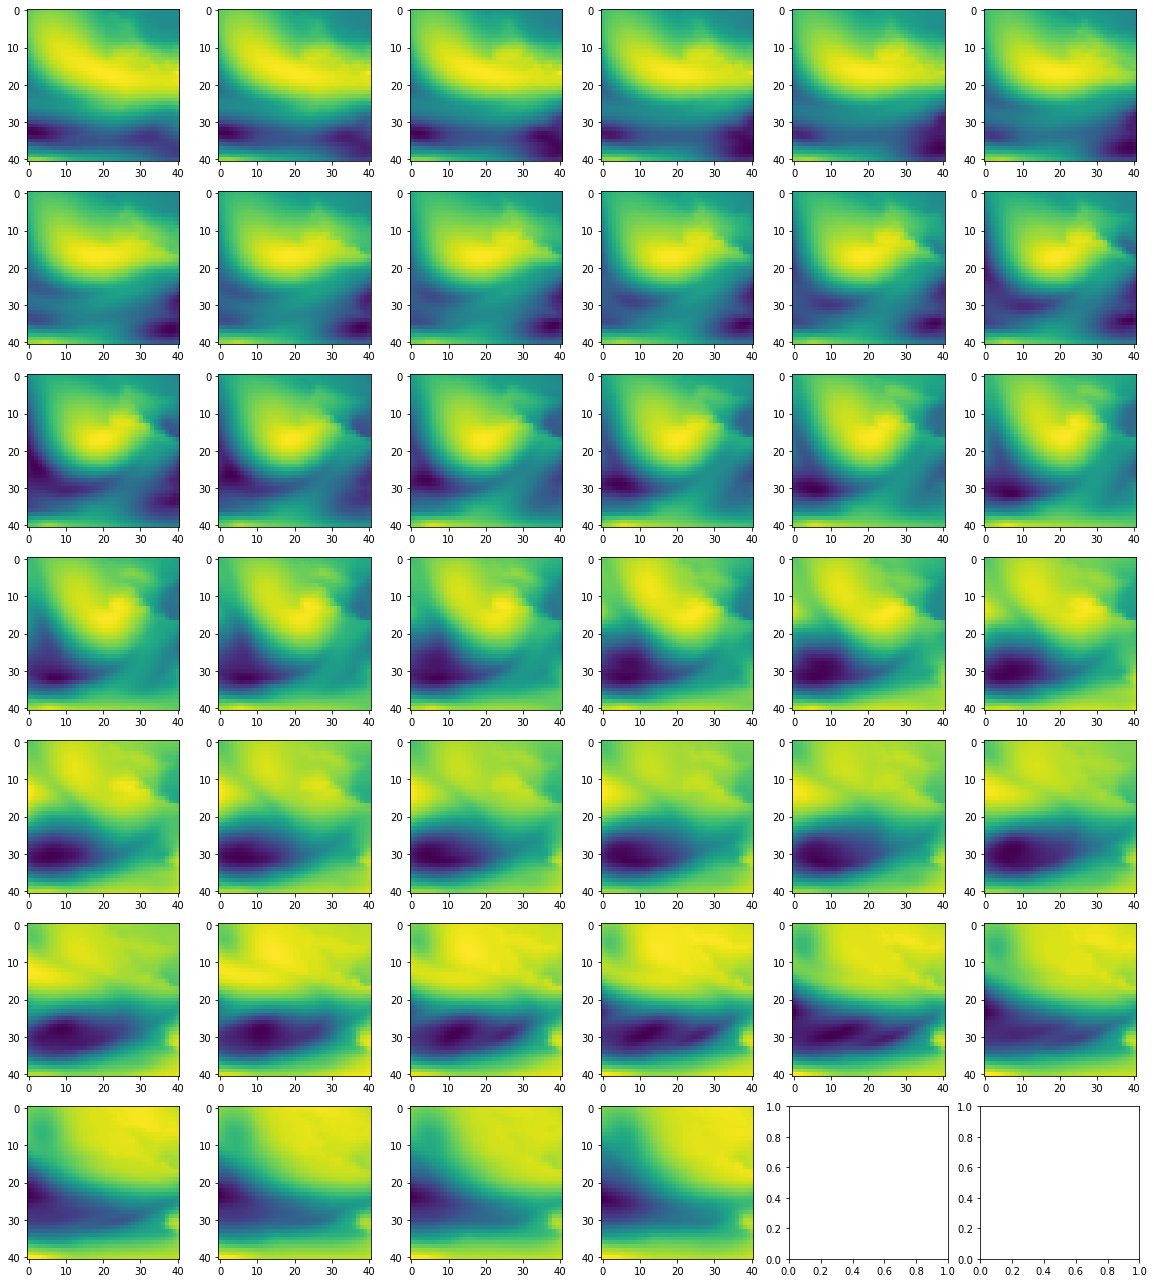

In [24]:
print(X_train['slp'].shape)

fig = plt.figure(figsize=(20,23))

axs = fig.subplots(7,6)

ligne = 0

for k in range(40):
    image = X_train['slp'][ligne, k, :, : ]     # Une image
    axs[k//6,k%6].imshow(image)
    
    # Enregistrement image par image :
    #plt.imshow(image)                       # 
    #plt.savefig(f"C:/Users/kevin/Documents/GitHub/M2_DataChallenge/images/tests/ligne_{ligne}_k_{k}")
plt.savefig(f"C:/Users/kevin/Documents/GitHub/M2_DataChallenge/images/tests/ligne_{ligne}")

In [25]:
import plotly.express as px
image = X_train['slp'][ligne, k, :, : ]     # Une image
fig = px.imshow(image)
fig.show()

In [ ]:
# TODO : A tester : prendre une image sur 2 / sur 3 / sur 4 ...

## D'autres tests plus ou moins utiles

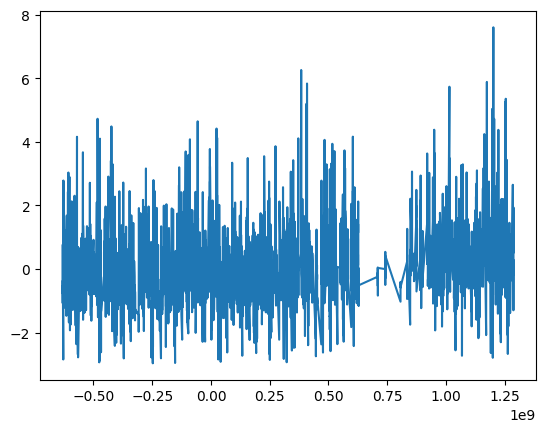

In [5]:
plt.plot(X_train['t_surge1_input'][:,0],X_train['surge1_input'][:,0])  
    # Chaque ligne (ici i=0) correspond à un jour
    # chaque colonne correspond à 1 heure précise, chaque jour
    

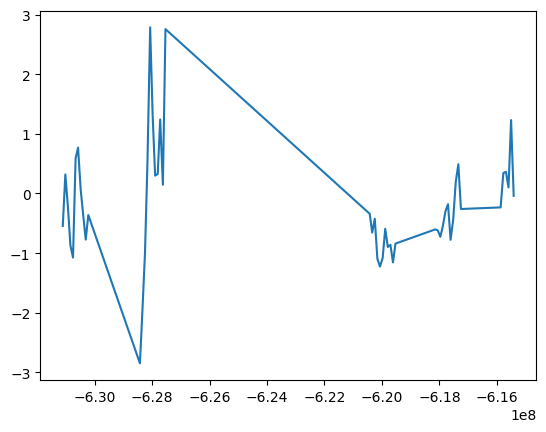

In [6]:
plt.plot(X_train['t_surge1_input'][:50,0],X_train['surge1_input'][:50,0])  
    # Chaque ligne (ici i=0) correspond à un jour
    # chaque colonne correspond à 1 heure précise, chaque jour

In [1]:
import datetime
import time
import calendar
time.gmtime(100000)

time.struct_time(tm_year=1970, tm_mon=1, tm_mday=2, tm_hour=3, tm_min=46, tm_sec=40, tm_wday=4, tm_yday=2, tm_isdst=0)

In [3]:
datetime.date.fromtimestamp(10)

datetime.date(1970, 1, 1)

In [7]:
datetime.datetime.utcfromtimestamp(-1000000)
calendar.timegm((1950,1,1,0,0,0,0))
time.gmtime(-100000)

OSError: [Errno 22] Invalid argument

In [12]:
# 40 images 41x41
print(np.shape(X_train['slp']))

(5599, 40, 41, 41)

In [16]:
def surge_prediction_metric(dataframe_y_true, dataframe_y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_columns = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_columns = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (weights * (dataframe_y_true[surge1_columns].values - dataframe_y_pred[surge1_columns].values)**2).mean()
    surge2_score = (weights * (dataframe_y_true[surge2_columns].values - dataframe_y_pred[surge2_columns].values)**2).mean()

    return surge1_score + surge2_score